# Earth's outgoing longwave radiation budget intercomparison for climate monitoring

Production date: 11-06-2025

Produced by: CNR-ISMAR, Claudia Allegrini, Andrea Storto, Vincenzo de Toma

## 🌍 Use case: Consistency assessment of Earth's Outgoing Longwave Radiation Budget products for climate monitoring

## ❓ Quality assessment question(s)
* **How consistent are Top of Atmosphere (TOA) outgoing longwave radiation from ERB satellite products (CLARA) with the equivalent variable ("mean top net long wave radiation flux") from the ERA5 reanalysis dataset?**

The Earth Radiation Budget (ERB) Top of the Atmosphere (TOA) Outgoing Longwave Radiation (OLR) product enables the quantification of the net longwave radiation at the top of the atmosphere, which is crucial for several climate applications. In particular, a non-exhaustive list of examples include: i) evaluation and constraining of climate models, as biases in simulated longwave fluxes directly affect estimates of radiative forcing and feedbacks; ii) monitoring a component of the Earth’s Energy Imbalance (EEI), since long-term departures between incoming solar and outgoing longwave radiation drive changes in the global climate system; iii) providing valuable information for diagnosing major climate modes such as ENSO, where shifts in deep convection are closely tied to longwave anomalies. Particularly, in the evaluation of climate models a crucial step is the choice of a reference dataset, which can be either satellite-derived or however observation-based, like for example CLARA-A3 and ERA5. The aim of this notebook is therefore to carry out an intercomparison of these two products, available from the Climate Data Store (CDS).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Overall consistency: Both datasets reproduce global Outgoing Longwave Radiation (OLR) patterns coherently, with regional differences generally small (<5 W/m² in the tropics) and good agreement in zonal averages, though ERA5 consistently shows higher values.

* Seasonal and latitudinal biases: ERA5 exhibits a stronger seasonal cycle (~5 W/m²) compared to CLARA‑A3, due to model‑based cloud and temperature amplitudes, while CLARA‑A3 retrieval limitations dampen variability, especially at high latitudes.

* Climate applicability: Despite regional discrepancies (Tropical Pacific, Western Australia, North Africa), both products provide a robust basis for monitoring Earth’s energy balance and evaluating climate models, with ERA5 offering stability and completeness, and CLARA‑A3 serving as an observational benchmark.
```

The estimation of outgoing longwave radiation (OLR) at the top of the atmosphere is crucial for understanding a component of the Earth's radiation budget (ERB), which plays a significant role in climate dynamics and energy balance. Despite its importance, accurately assessing OLR-ERB variability by intercomparing remote sensing data and reanalysis can help to point out eventual inconsistencies, and to choose as reference data to validate simulations one or the other ([[1]](https://doi.org/10.1175/2008JCLI2637.1); 
[[2]](https://doi.org/10.1038/35066553); [[3]](https://doi.org/10.1002/qj.3803)).

```{figure} attachment:8121909e-6679-4e6c-9d68-0781310bd00f.png
Monthly Climatology averaged Globally, and in the Northern and Southern Hemisphere, respectively.
```
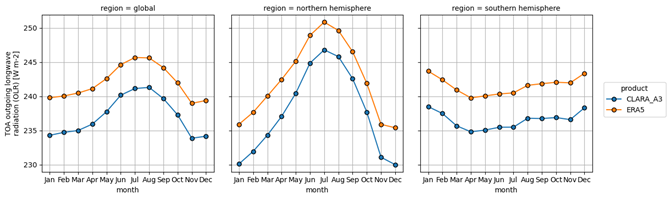

## 📋 Methodology

In this notebook we inter-compare the following catalogue entries from the Climate Data Store (CDS) by C3S:
1. CLARA-A3 TOA Outgoing Longwave Radiation (Satellite-Derived): This product is derived from satellite observations as part of the third generation of the CM SAF cLoud, Albedo, and Radiation dataset from AVHRR (CLARA-A3). It provides global coverage of monthly mean of top of the atmosphere net outgoing longwave radiation, calculated through radiative transfer models applied to cloud and surface properties retrieved from satellite instruments. This dataset represents observational estimates of the amount of shortwave radiation energy reaching the lower boundary of the atmosphere per unit of time and area from above. (for further information see [CLARA-A3 Overview Page](https://cds.climate.copernicus.eu/datasets/satellite-surface-radiation-budget?tab=overview)).
2. ERA5 Mean Top Net Long Wave Radiation Flux (avg_tnlwrf) (Reanalysis): The ERA5 product is the fifth-generation ECMWF atmospheric reanalysis, providing hourly estimates of atmospheric, land, and oceanic variables. avg_sdswrf is not a direct observation but is the result of numerical weather prediction and climate models assimilating vast amounts of global data, and provided as a monthly averaged flux. It is considered a highly consistent and frequently used reference dataset for energy and climate studies due to its stability and high resolution. (for further detail see [ERA5 Overview Page](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)).

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](choose-the-data-to-use-and-setup-code)**

**[](download-and-transform)**

**[](plot-spatial-weighted-time-series)**

**[](plot-time-weighted-means)**

**[](plot-spatial-weighted-zonal-means)**

## 📈 Analysis and results

(choose-the-data-to-use-and-setup-code)=
### 1. Choose the data to use and setup code

In this section, we import the required packages and set up the dataset names for further use in the following sections. Processing functions are also defined. We select only complete years available for each dataset in order to have a fair comparison between different products.

In [1]:
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/detoma_vincenzo/.cdsapirc")
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from cartopy import crs as ccrs, feature as cfeature
import cartopy.mpl.ticker as cticker
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
import warnings
warnings.filterwarnings("ignore")

# Variable to analyse
variable = "outgoing_longwave"
request_dicts = []

# Region for timeseries
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "northern hemisphere": {"lat_slice": slice(0, 90), "lon_slice": slice(0, 360)},
    "southern hemisphere": {"lat_slice": slice(-90, 0), "lon_slice": slice(0, 360)},
}

collection_ids = ["satellite-earth-radiation-budget", "reanalysis-era5-single-levels-monthly-means"]
chunks = {"year": 1}

request_dict = {
    "CLARA_A3": {
        "start": "1979-01", 
        "stop": "2020-12", 
        "product_family": "clara_a3",
        "origin": "eumetsat",
        "variable": f"{variable}_radiation",
        "climate_data_record_type": "thematic_climate_data_record",
        "time_aggregation": "monthly_mean",
    },
    "ERA5": {
        "start":"1979-01", 
        "stop" :"2020-12", 
        "product_type": "monthly_averaged_reanalysis",
        "time": "00:00",
        "data_format": "grib",
        "download_format": "zip",
        "variable": "mean_top_net_long_wave_radiation_flux",
    }
}
request_dicts.append(request_dict)

def preprocess_time(ds):
    if "time" in ds and "units" in ds["time"].attrs:
        # Could not decode
        ds = ds.squeeze("time", drop=True)
    if "time" not in ds:
        time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
        ds = ds.expand_dims(time=[time])
    return ds


def spatial_weighted_mean(ds, lon_slice, lat_slice, regrid, ds_obj, SKIP, mask=None):
    if mask is None:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds, weights=True, skipna=SKIP)
    else:
        if regrid==True:
            ds = diagnostics.regrid(ds, ds_obj, method='bilinear', skipna=SKIP)
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
        mask = utils.regionalise(mask, lon_slice=lon_slice, lat_slice=lat_slice)
        return diagnostics.spatial_weighted_mean(ds.where(~np.isnan(mask)), weights=True, skipna=SKIP)

xarray_kwargs = {
    "drop_variables": ["time_bounds", "record_status"],
    "preprocess": preprocess_time,
}

(download-and-transform)=
### 2. Download and transform

The code below will download the products, and build a mask to make the comparison fair. Indeed, in CLARA-A3 there is an ancillary variable called "number_of_lw_daily_means", which indicates the number of daily averages used to calculate the monthly mean, for each of the monthly record in CLARA-A3. By flagging times and locations where the monthly average has not been calculated on a complete month, we can have a fair comparison with ERA5, to which the same mask is applied too.

In [2]:
weights=True
skipna=True
p = []
DS = {}
for request_dict in request_dicts:
    Ds = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)
    
        start = request.pop("start")
        stop = request.pop("stop")
        
        requests = download.update_request_date(
            request, start=start, stop=stop, stringify_dates=True
        )
    
        ds = download.download_and_transform(
            collection_id,
            requests,
            chunks=chunks,
            transform_chunks=False,
            **xarray_kwargs,
            quiet=True,
        )
        Ds[product] = ds
    DS[variable] = Ds

In [3]:
navg_obs_month = DS['outgoing_longwave']['CLARA_A3']['number_of_lw_daily_means']

In [4]:
avgdays_in_month = DS['outgoing_longwave']['CLARA_A3'].time.dt.daysinmonth

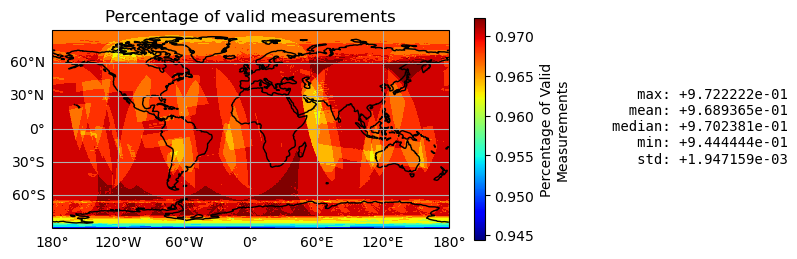

In [5]:
mask = xr.where(navg_obs_month==avgdays_in_month, 1, np.nan) 
# mask where the number of daily averages in that month is not equal to the number of days in that given month.
valid_over_time = mask.count('time') / len(mask.time)
valid_over_time = valid_over_time.rename('Percentage of Valid Measurements')
p = plot.projected_map(valid_over_time, show_stats=True, cmap='jet', cbar_kwargs={'shrink':0.6})
p.axes.set_title('Percentage of valid measurements')
p.figure.figsize = (12,5)

The global map of the percentage of valid measurements is everywhere higher than 94%, with a pattern showing stripes which resembles satellite tracks. We followed the recommendation of paragraph 3.5.3 of the [CLARA-A3 PUM](https://www.cmsaf.eu/SharedDocs/Literatur/document/2023/saf_cm_rmib_pum_gac_toa_1_2_pdf.pdf?__blob=publicationFile), and decided to be very strict, selecting only monthly averages which are calculated on complete months in all the diagnostics below.

Text(0.5, 0.98, 'Lat-Lon Yearly-Averaged Percentage of Valid Measurements')

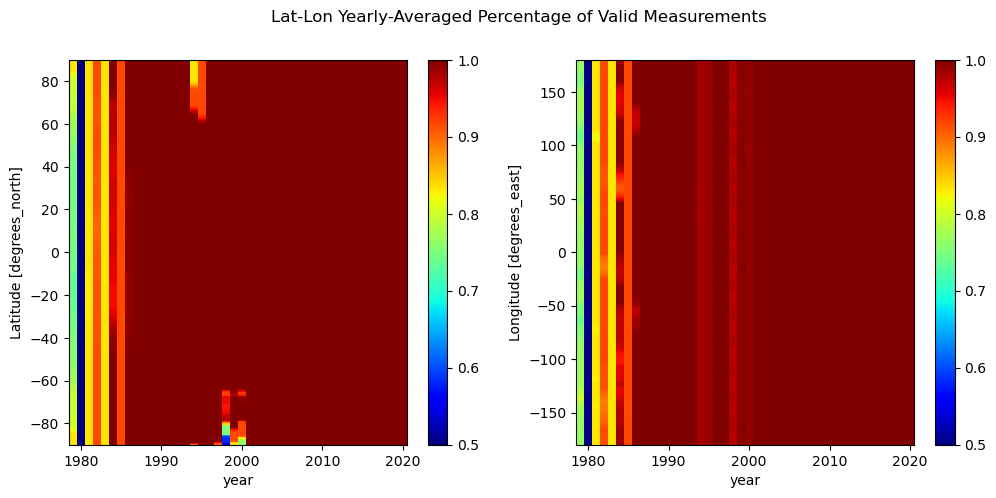

In [6]:
valid_lat_time = mask.count('longitude') / len(mask.longitude)
valid_lon_time = mask.count('latitude') / len(mask.latitude)
fig = plt.figure(1, figsize=(12,5))
ax = fig.add_subplot(121)
Ax = fig.add_subplot(122)
valid_lat_time.groupby('time.year').mean('time').plot(ax=ax, x='year', cmap='jet')
valid_lon_time.groupby('time.year').mean('time').plot(ax=Ax, x='year', cmap='jet')
fig.suptitle(f'Lat-Lon Yearly-Averaged Percentage of Valid Measurements')

Latitudinal and longitudinal patterns show a very homogeneous percentage of valid monthly means after the first years of the record.

In [7]:
def mean_map_period(ds, start, stop, W, S):
    selection = ds.sel(time=slice(start, stop))
    time_coord =  np.array(pd.date_range(start, stop, freq='MS'), dtype=np.datetime64)
    ds = selection.assign_coords({'time':('time', time_coord, selection.time.attrs)})
    ds_map = diagnostics.time_weighted_mean(ds, weights=W, skipna=S)
    return ds_map

In [8]:
def get_varname(ds, variable):
    if variable=="outgoing_longwave":
        varnames = (
            {"olr", "avg_tnlwrf", "LW_flux"}
        )
        
    (varname,) = set(ds.data_vars) & varnames
    return varname

ds_maps = {}
p = []
for request_dict in request_dicts:
    da_maps = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CLARA_A3":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = da.drop('time').rename({'forecast_reference_time':'time'}).assign_coords(time=da_obj.time)
            da = diagnostics.regrid(da, da_obj, method='bilinear')
            da = -1*da
        da.attrs.update({"start": start, "stop": stop})
        da = da*mask
        da_maps[product] = diagnostics.time_weighted_mean(da, weights=True, skipna=True)
        
    ds_maps[variable] = da_maps

In [9]:
ds_timeseries = {}
p = []
for request_dict in request_dicts:
    da_timeseries = {}
    for collection_id, (product, request) in zip(collection_ids, request_dict.items()):
        p.append(product)

        ds = DS[variable][product]
        
        varname=get_varname(ds, variable)
        
        da = ds[varname]
        if product=="CLARA_A3":
            regrid=False
            da_obj = ds[varname]
        else:
            regrid=True
            da = da.drop('time').rename({'forecast_reference_time':'time'}).assign_coords(time=da_obj.time)
            da = diagnostics.regrid(da, da_obj, method='bilinear')
            da = -1*da
        da.attrs.update({"start": start, "stop": stop})
        
        regrid_dict={'regrid':regrid, 'ds_obj':da_obj}

        SkipNa={'SKIP': True}

        Mask = {'mask': mask}
        
        dataarrays = []
        for region, slices in region_slices.items():
            dall = {}
            dall.update(slices)
            dall.update(regrid_dict)
            dall.update(SkipNa)
            dall.update(Mask)
            da_ts = spatial_weighted_mean(da,
                                          lon_slice=dall['lon_slice'],
                                          lat_slice=dall['lat_slice'],
                                          regrid=dall['regrid'],
                                          ds_obj=dall['ds_obj'],
                                          SKIP=dall['SKIP'],
                                          mask=dall['mask'])
            dataarrays.append(da_ts.expand_dims(region=[region]))
        
        da = xr.concat(dataarrays, "region")
        da.attrs.update({"start": start, "stop": stop})
        da_timeseries[product] = da.rename(variable)
    ds_timeseries[variable] = da_timeseries

(plot-spatial-weighted-time-series)=
### 3. Plot spatial weighted time series

Below, we calculate and plot spatially weighted means for CLARA-A3 and ERA5, in terms of montly climatologies. We want here to inspect how the different products reproduce the seasonal cycle, both for the global mean, and for each hemisphere. 

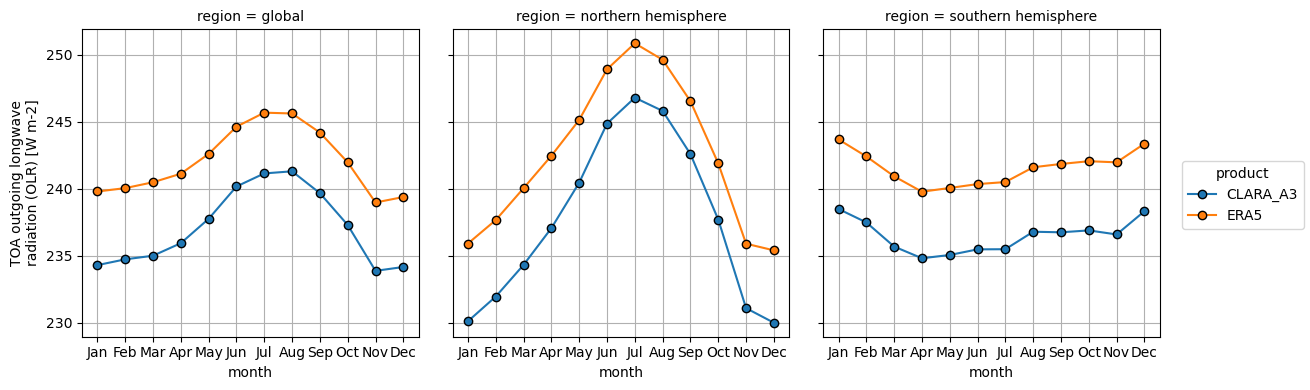

In [10]:
lw_ts = xr.concat([ds_timeseries['outgoing_longwave'][k] for k in ds_timeseries['outgoing_longwave'].keys()], 
                  dim='product', 
                  coords='minimal').assign_coords({'product': [k for k in ds_timeseries['outgoing_longwave'].keys()]})
t1 = lw_ts.groupby('time.month').mean('time').plot(col='region', hue='product', figsize=(12,4), marker='o', markeredgecolor='k') #.resample(time='1M').mean()
for ax in t1.axs.flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid()
    

The pronounced seasonality in OLR is mostly linked with the larger land area in the Northern Hemisphere. In both hemispheres and also globally ERA5's top net longwave radiation is systematically higher, with a difference of about $5\, W\,m^{-2}$. The $\sim 5\, W\, m^{-2}$ larger seasonal cycle in ERA5 is likely due to model-based cloud and temperature seasonal amplitudes being stronger than in the satellite retrievals, combined with retrieval limitations in CLARA-A3 that tend to dampen variability, particularly at high latitudes ([[3]](https://doi.org/10.1002/qj.3803), [[4]](https://doi.org/10.5676/EUM_SAF_CM/CLARA_AVHRR/V003)).

(plot-time-weighted-means)=
### 4. Plot time weighted means
Below, we calculate and plot time-weighted means for the two datasets.

Text(0.5, 0.98, 'Mean map on the period 1979-2020')

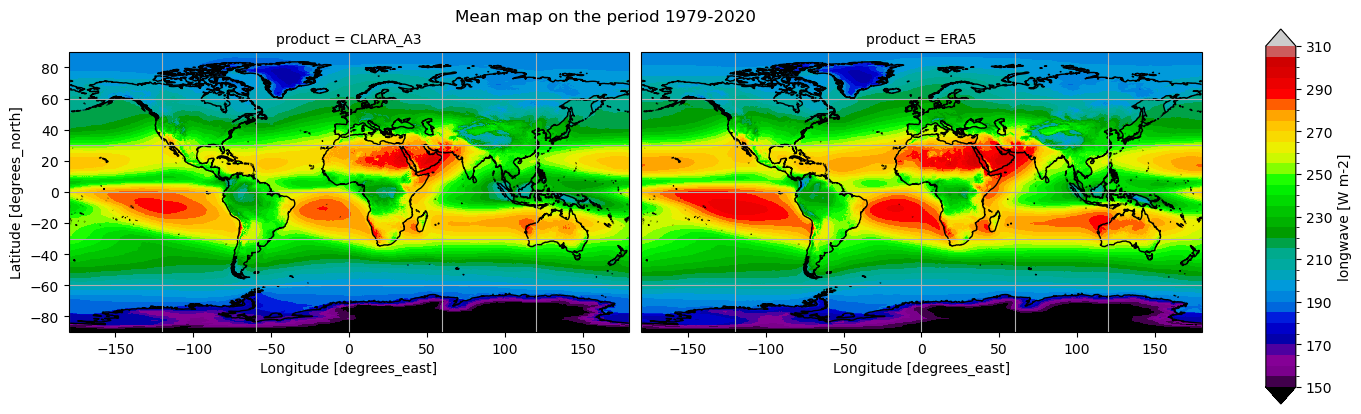

In [11]:
p_to_show = ['CLARA_A3', 'ERA5']
lw_maps = xr.concat([ds_maps['outgoing_longwave'][p] for p in p_to_show], dim='product').assign_coords({'product': p_to_show})
lw_maps_masked = lw_maps
times = lw_ts.time
p1 = lw_maps_masked.plot(figsize=(12,5),
                         col='product', 
                         col_wrap=2,
                         subplot_kws={'projection': ccrs.PlateCarree()},
                         levels=range(150, 315, 5),
                         extend="both",
                         cmap="nipy_spectral",
                         add_colorbar=False,
                         transform=ccrs.PlateCarree())
for ax in p1.axs.flat:  # loop through the map axes
    subplotspec = ax.get_subplotspec()
    if subplotspec.is_last_row():
        ax.xaxis.set_visible(True)
    if subplotspec.is_first_col():
        ax.yaxis.set_visible(True)
    ax.coastlines('50m')
    ax.gridlines()
p1.fig.set_layout_engine("compressed")
cax = p1.fig.add_axes([1.05, 0.1, 0.025, 0.75])
p1.add_colorbar(cax=cax, orientation='vertical', label=r'longwave [W m-2]')
p1.fig.suptitle(f'Mean map on the period {times.dt.year[0].values}-{times.dt.year[-1].values}')

Time-mean spatial maps reveal broadly consistent large-scale patterns across the two products, though notable regional discrepancies remain — for instance near the Equator, over the Tropical Pacific, Western Australia, and parts of North Africa. Since the applied masking removes the potential inconsistency linked to how monthly means are constructed — with ERA5 averaging over all days of each month, while CLARA-A3 relies on the availability of valid satellite scenes — the remaining offsets likely stem from inherent differences in the datasets themselves. As discussed above, ERA5 tends to produce stronger seasonal variations in cloudiness and atmospheric temperature due to its model-based cloud and radiation schemes, whereas CLARA-A3 is subject to retrieval limitations associated with AVHRR measurements. These limitations, especially pronounced at high latitudes, often dampen the true variability in CLARA-A3 fluxes, offering a coherent explanation for the spatial differences seen in the mean maps ([[3]](https://doi.org/10.1002/qj.3803), [[4]](https://doi.org/10.5676/EUM_SAF_CM/CLARA_AVHRR/V003)).

Despite these differences, both products reproduce the main global OLR features: highest values over subtropical deserts (e.g., Sahara, Arabian Peninsula, central Australia) and over clear-sky regions in the eastern subtropical ocean gyres, and lowest values in areas of deep convection (ITCZ, tropical rainforests) and at high latitudes under cloud cover. Both datasets capture the major “warm” desert maxima and “cold” convective minima. Differences remain small (<5 W m⁻²) within the well-observed tropical belt.


(plot-spatial-weighted-zonal-means)=
### 5. Plot spatial weighted zonal means
The code below will calculate and plot weighted zonal mean.

Text(0.5, 0, 'outgoing_longwave [W m-2]')

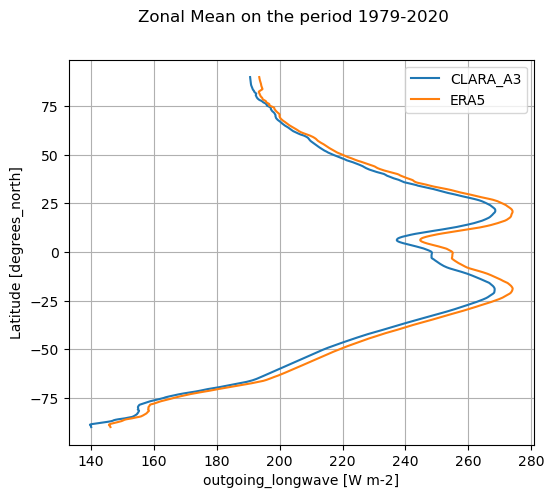

In [12]:
fig=plt.figure(5, figsize=(6,5))
ax1 = fig.add_subplot(111)
fig.suptitle(f'Zonal Mean on the period {times.dt.year[0].values}-{times.dt.year[-1].values}')
da_maps = ds_maps[variable]
ax=ax1 if variable=='outgoing_longwave' else ax2
for product, da in da_maps.items():
    da = diagnostics.spatial_weighted_mean(da, dim="longitude")
    da.plot(ax=ax, y="latitude", label=product)
ax.legend(loc='best')
ax.grid()
ax.set_title('')
ax.set_xlabel(f"{variable} [W m-2]")

Zonal averages indicate the good consistency between the products, with the offset being larger at mid-latitudes than at high-latitudes.

#### Discussion and applications

Satellite-derived outgoing longwave radiation (OLR) is a valuable metric in climate investigations, offering key insights into the Earth’s energy balance and the distribution of atmospheric and surface temperatures. Instruments such as the National Oceanic and Atmospheric Administration’s (NOAA) Advanced Very High Resolution Radiometer (AVHRR) and the Atmospheric Infrared Sounder (AIRS) onboard NASA’s Aqua satellite provide long-term, observation-based estimates of OLR that are essential for monitoring cloud cover, humidity, and the thermal properties of the Earth’s surface and atmosphere. In parallel, reanalyses such as ERA5 complement these satellite datasets by providing globally complete and physically consistent OLR fields derived from a combination of observations and model-based radiation and cloud schemes. Together, these products form a critical basis for understanding radiative flux variability, evaluating climate models, and diagnosing changes in the Earth’s energy budget ([[3]](https://doi.org/10.1002/qj.3803), [[5]](https://doi.org/10.1029/2012JD017997)). For example, regional studies tried to find relationships between Arctic and Antarctic Oscillations with the OLR, demonstrating how variations in sea-ice cover modulate the outgoing longwave flux and influence the processes driving polar amplification [[6]](https://doi.org/10.1175/1520-0442%282003%29016%3C1583:ROTAAA%3E2.0.CO;2). In addition, OLR has proven valuable for evaluating regional climate models and improving their representation of radiative processes, thereby enhancing confidence in projections of future climate conditions. Benchmarking model outputs against multi-decadal OLR records has also contributed to more constrained estimates of water-vapor and cloud feedbacks, helping to refine expectations of future surface warming ([[7]](https://doi.org/10.1017/9781009157896)).

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1175/2008JCLI2637.1) Loeb, N. G., Wielicki, B. A., Doelling, D. R., Smith, G. L., Keyes, D. F., Kato, S., ... & Wong, T. (2009). Toward optimal closure of the Earth's top-of-atmosphere radiation budget. Journal of Climate, 22(3), 748-766

[[2]](https://doi.org/10.1038/35066553) Harries, J. E., Brindley, H. E., Sagoo, P. J., & Bantges, R. J. (2001). Increases in greenhouse forcing inferred from the outgoing longwave radiation spectra of the Earth in 1970 and 1997. Nature, 410(6826), 355-357.

[[3]](https://doi.org/10.1002/qj.3803) Hersbach, H., Bell, B., Berrisford, P., Hirahara, S., Horányi, A., Muñoz‐Sabater, J., ... & Thépaut, J. N. (2020). The ERA5 global reanalysis. Quarterly journal of the royal meteorological society, 146(730), 1999-2049.

[[4]](https://doi.org/10.5676/EUM_SAF_CM/CLARA_AVHRR/V003) Karlsson, K. G., Stengel, M., Meirink, J. F., Riihelä, A., Trentmann, J., Akkermans, T., ... & Hollmann, R. (2023). CLARA-A3: The third edition of the AVHRR-based CM SAF climate data record on clouds, radiation and surface albedo covering the period 1979 to 2023. Earth System Science Data, 15(11), 4901-4926.
 
[[5]](https://doi.org/10.1029/2012JD017997) Susskind, J., G. Molnar, L. Iredell, et al., 2012: Interannual variability of outgoing longwave radiation as observed by AIRS and CERES. J. Geophys. Res. Atmos., 117, D23107, doi: 10.1029/2012JD017997.

[[6]](https://doi.org/10.1175/1520-0442%282003%29016%3C1583:ROTAAA%3E2.0.CO;2) Miller, A. J., Zhou, S., & Yang, S. K. (2003). Relationship of the Arctic and Antarctic Oscillations to the outgoing longwave radiation. Journal of climate, 16(10), 1583-1592.

[[7]](https://doi.org/10.1017/9781009157896) IPCC, 2021: Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.). Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, 2391 pp. https://doi.org/10.1017/9781009157896